In [ ]:
## En caso de que decidas trabajar localmente, se recomienda crear un ambiente
## e instalar las librerías. Además deberás cargar localmente las imágenes.
!pip install pandas
!pip install matplotlib
!pip install mediapipe
!pip install opencv-python

  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.

ERROR: Operation cancelled by user
^C


In [1]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import mediapipe as mp
from tqdm import tqdm
import kagglehub

/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/My Drive/Data-IIC2613/

/content/drive/My Drive/Data-IIC2613


##### Este codigo genera los datasets con los landmarks automáticamente. No modificar.

In [4]:
path = kagglehub.dataset_download("glushko/rock-paper-scissors-dataset")

print("Path to dataset files:", path)

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)
mp_drawing = mp.solutions.drawing_utils

def extract_landmarks(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = hands.process(img_rgb)

    if results.multi_hand_landmarks:
        # Solo usamos la primera mano detectada
        hand_landmarks = results.multi_hand_landmarks[0]
        # Extraer x, y, z de cada landmark
        coords = []
        for lm in hand_landmarks.landmark:
            coords.extend([lm.x, lm.y, lm.z])
        return coords
    return None

def process_dataset(base_dir):
    data = []
    for label in os.listdir(base_dir):  # carpetas: rock, paper, scissors
        label_dir = os.path.join(base_dir, label)
        if not os.path.isdir(label_dir):
            continue
        for img_file in tqdm(os.listdir(label_dir), desc=f"Procesando {label}"):
            img_path = os.path.join(label_dir, img_file)
            features = extract_landmarks(img_path)
            if features:
                data.append(features + [label, img_file])
    return data

dataset_dir = path
train_dir = os.path.join(dataset_dir, "train")
test_dir = os.path.join(dataset_dir, "test")

print("Procesando TRAIN...")
train_data = process_dataset(train_dir)
print("Procesando TEST...")
test_data = process_dataset(test_dir)

columns = [f"x{i}" for i in range(21*3)] + ["label", "filename"]
df_train = pd.DataFrame(train_data, columns=columns)
df_test = pd.DataFrame(test_data, columns=columns)

df_train.to_csv("train_landmarks.csv", index=False)
df_test.to_csv("test_landmarks.csv", index=False)

Using Colab cache for faster access to the 'rock-paper-scissors-dataset' dataset.
Path to dataset files: /kaggle/input/rock-paper-scissors-dataset
Procesando TRAIN...


Procesando scissors: 100%|██████████| 329/329 [00:16<00:00, 19.49it/s]


Procesando TEST...


Procesando scissors: 100%|██████████| 176/176 [00:09<00:00, 17.84it/s]


In [ ]:
print(df_train)

           x0        x1            x2        x3        x4        x5        x6  \
0    0.841949  0.800062  1.381900e-06  0.683716  0.874071 -0.077545  0.478766   
1    0.180261  0.544027  7.403968e-07  0.247709  0.395878  0.015373  0.354759   
2    0.394616  0.478654  5.847687e-07  0.314639  0.505740 -0.040087  0.217509   
3    0.760149  0.878420  8.183883e-07  0.658940  0.836737 -0.055122  0.579618   
4    0.781348  0.698561  5.039903e-07  0.696788  0.643512 -0.041527  0.635237   
..        ...       ...           ...       ...       ...       ...       ...   
888  0.088335  0.816867  1.686296e-06  0.102083  0.617375  0.062632  0.146422   
889  0.449196  0.790009  1.309116e-06  0.345082  0.786779 -0.046734  0.239190   
890  0.870964  0.710354  2.562134e-07  0.791592  0.606602  0.027491  0.690954   
891  0.563186  0.405883  1.120102e-06  0.451203  0.384136 -0.162300  0.358109   
892  0.707873  0.180277  1.665453e-06  0.592739  0.146415 -0.180807  0.475183   

           x7        x8    

### Primera parte: Landmarks de las manos.

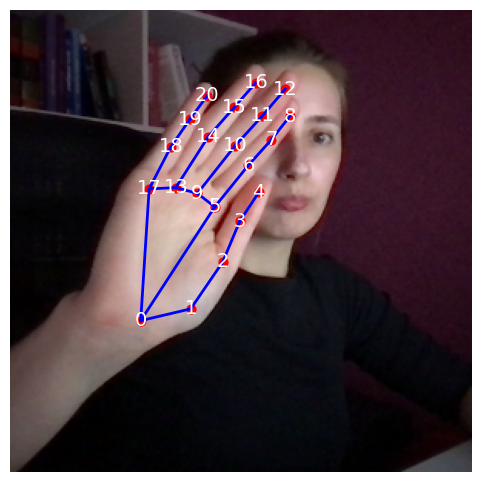

In [9]:
def imprimir_landmarks(subdataset: str, label: str, image_name: str):
    image_path = f'hands/{subdataset}/{label}/{image_name}'
    mp_hands = mp.solutions.hands
    mp_drawing = mp.solutions.drawing_utils

    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    with mp_hands.Hands(static_image_mode=True, max_num_hands=1) as hands:
        results = hands.process(img_rgb)

    hand_landmarks = results.multi_hand_landmarks[0]
### Debes encontrar una forma de procesar las coordenadas X, Y y las conexiones de las manos (Hand Connections)
    x = [landmark.x for landmark in hand_landmarks.landmark]
    y = [landmark.y for landmark in hand_landmarks.landmark]

    # Obtener las conexiones de las manos de MediaPipe
    hand_connections = mp_hands.HAND_CONNECTIONS
### Ploteo de las coordenadas + landmarks.
    plt.figure(figsize=(6,6))
    plt.imshow(img_rgb)
    plt.axis("off")

    for (i, j) in hand_connections:
        plt.plot(
            [x[i] * img_rgb.shape[1], x[j] * img_rgb.shape[1]],
            [y[i] * img_rgb.shape[0], y[j] * img_rgb.shape[0]],
            c="blue", linewidth=2
        )

    for i, (xi, yi) in enumerate(zip(x, y)):
        plt.scatter(xi * img_rgb.shape[1], yi * img_rgb.shape[0], c="red", s=40)
        plt.text(xi * img_rgb.shape[1], yi * img_rgb.shape[0], str(i),
                 fontsize=14, color="white", ha="center", va="center")

    plt.show()

imprimir_landmarks("test","paper","nasmi_347.png")

### Segunda parte: Features

In [ ]:
# Distancia 8 - 12 x
# Distancia 8 - 12 y
# Distancia 12 - 16 x
# Distancia 12 - 16 y
# Distancia 0 - 4
# Distancia 12 - 0
# Distancia

### Tercera Parte: Modelos de ML


Decision Tree

In [ ]:
### Empieza a escribir tu código aquí

SVM

In [ ]:
### Empieza a escribir tu código aquí

Random Forest

In [ ]:
### Empieza a escribir tu código aquí

### Bonus

In [ ]:
### Empieza a escribir tu código aquí